In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from prep_data import Dataset 
from torch.utils.data import DataLoader
from LSTM_Net import LSTM_Net 
import torch.nn as nn 
import torch 
import numpy as np
import math 
import random
import gc
import time 
from skimage.transform import resize
from util import * 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os,sys


from torch.utils.tensorboard import SummaryWriter


### SEED for reproducability  

In [2]:
torch.backends.cudnn.deterministic = True
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)



In [3]:
## GPU 
os.environ["CUDA_VISIBLE_DEVICES"]= '3'


## Global variables 

In [4]:
# data paths and parameters
data_path = '../LSTM_SEAM_submitted_v2/data'
base_path = f"{data_path}/base_seam.npy" 
mon_path = f"{data_path}/mon_seam.npy" 

parm = {
 'nt': 2500,
 'ng': 501,
 'ns': 60,
 'dt':  0.0024,
 'dg': 0.02500000037252903,
 'ds': 0.17499999701976776,
 'ot': 0.0,
 'og': 0.0,
 'os': 1.0}
 

mxoffset = 5 # km 


# Hyperparameters for training
batchsz = 64 
num_epochs = 300 
LR = 0.002
hsz = 100
act = 'tanh'
n_layer=2
bias= False
dropout = 0.0


# define the overburden window 
# start= 100 
# last = 650 

feature_length=41

# # define the overburden window 
start = 550
last =  900 

epoch=0

hyperpar = f"_lr{LR}_nlayer{n_layer}_act{act}_bias{bias}_batchsz{batchsz}-featurelength{feature_length}_time_start{start}_end{last}_mxoffset{mxoffset}"

net_path = "./Network/"

# -----------------------------------------------#
# RSF PATH 
# path = '/home/alaliaa/Time_lapse_ML/ML_Models2/data/'
# base = path + 'Base_data.rsf'
# mon = path + 'MonNoisy_data.rsf'

In [5]:

base = np.load(base_path)
mon = np.load(mon_path)
 
ns,ng,nt = base.shape
print ('ns',ns,'ng',ng,'nt',nt)

# base = muting(base,mxoffset,parm)
# mon  = muting(mon,mxoffset,parm)

# # Take only few shots 
# base = base[30:50,]
# mon = mon[30:50,]
# ns,ng,nt_ = base.shape

# Take only few shots 
# base = base[20:40:2,]
# mon = mon[20:40:2,]
# ns,ng,nt_ = base.shape




base = base.reshape((ns*ng,nt))
mon = mon.reshape((ns*ng,nt))

print('data shapeed to 2d',base.shape)


ns 60 ng 501 nt 2500
data shapeed to 2d (30060, 2500)


In [6]:

# skip=3
# base = base[::skip,]
# mon = mon[::skip,]
# print(f"data shape after slipping {skip} traces: {base.shape}")

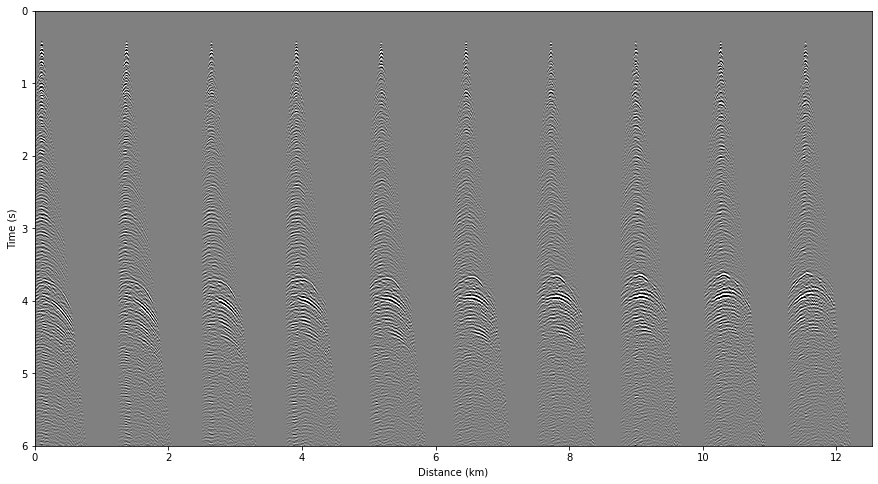

In [7]:
def Plot_shot(data,par):
    vmin, vmax = np.percentile(data, [2,98])
    plt.figure(figsize=(15,8))
    plt.imshow(data[0*ng:10*ng,:].T, aspect='auto',
           vmin=vmin, vmax=vmax,cmap='gray',extent=[par['og'],par['dg']*par['ng']+par['og'],
                                                    par['nt']*par['dt']+par['ot'],par['ot']])
    plt.ylabel('Time (s)')
    plt.xlabel('Distance (km)')

# This plot 2D concatenated shots 
Plot_shot(base-mon,parm)

In [8]:
''' Pre Processing the data for trainign 
    - specify the overburden time window 
    - split the data into training and testing 
    - scale the data 

'''

def scale_data(data=None):
    print('shape of data that will be scaled', data.shape)
    assert len(data.shape)==2
    ng,nt = data.shape  
    
    data = data.T
    scaler= MinMaxScaler(feature_range=(-1,1))
    # scaler= StandardScaler()
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    scaled_data = scaled_data.T 


    return scaled_data,scaler
         


def min_max_custom(seq,a,b): 
    minx = seq.min()
    maxx = seq.max()
    seq = (b-a) * (seq-minx)/(maxx-minx)  + a 
    return seq, minx,maxx
def min_max_fit_custom(seq,a,b,minx,maxx): 

    seq = (b-a) * (seq-minx)/(maxx-minx)  + a 
    return seq


 
base = base[:,start:last]
base = base[~np.all(base==0 , axis=1)] # this exclude the zero traces 
mon = mon[:,start:last]   
mon = mon[~np.all(mon==0 , axis=1)] # this exclude the zero traces 


# split data 
test_size = 0.2
base_train,base_test,mon_train,mon_test  =  train_test_split(base,mon,test_size=test_size,shuffle=True)




Ntrain = base_train.shape[0]
Ntest = base_test.shape[0]



# scaling
# base_train, base_train_scaler = scale_data(base_train) 
# mon_train , mon_train_scaler  = scale_data(mon_train) 
# base_test , base_test_scaler  = scale_data(base_test) 
# mon_test  , mon_test_scaler   = scale_data(mon_test) 

base_train,min_in,max_in = min_max_custom (base_train,-1,1)
mon_train,min_op,max_op = min_max_custom (mon_train,-1,1)
base_test = min_max_fit_custom(base_test,-1,1,min_in,max_in)
mon_test  = min_max_fit_custom(mon_test,-1,1,min_op,max_op)

# move to torch 
base_train = torch.from_numpy(base_train).double()
mon_train  = torch.from_numpy(mon_train).double()
base_test  = torch.from_numpy(base_test).double()
mon_test   = torch.from_numpy(mon_test).double()



In [9]:
import pickle 


minmax = {'min_in':min_in, 'max_in':max_in, 'min_op':min_op, 'max_op':max_op}

# with open('./mu_std.pck','wb') as f:
#     pickle.dump(mu_std,f)

with open('./minmax.pck','wb') as f:
    pickle.dump(minmax,f)


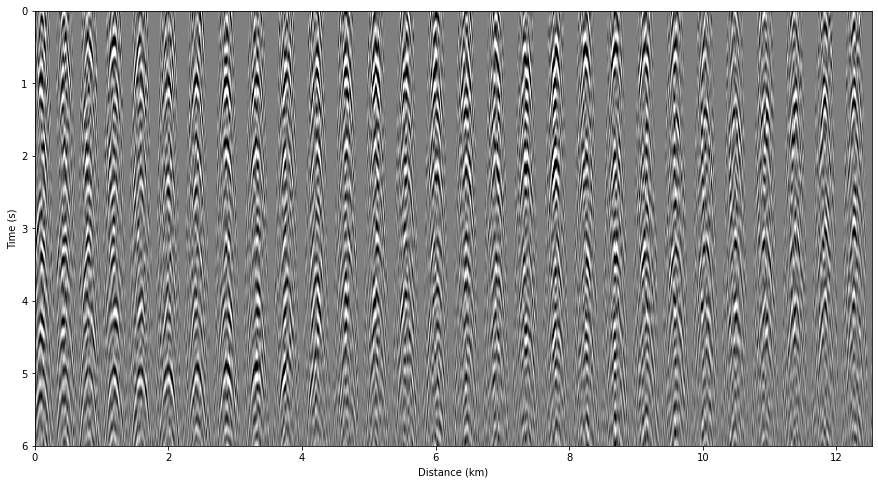

In [10]:
def Plot_shot(data,par):
    vmin, vmax = np.percentile(data, [2,98])
    plt.figure(figsize=(15,8))
    plt.imshow(data[0*ng:10*ng,:].T, aspect='auto',
           vmin=vmin, vmax=vmax,cmap='gray',extent=[par['og'],par['dg']*par['ng']+par['og'],
                                                    par['nt']*par['dt']+par['ot'],par['ot']])
    plt.ylabel('Time (s)')
    plt.xlabel('Distance (km)')

# This plot 2D concatenated shots 
Plot_shot(base,parm)

# Prepare input window

In [11]:
def window (x,dimension=-1,size=11,step=1):
    ''' x has to be pytorch tensor'''
    return x.unfold(dimension,size,step)


print(base_train.shape)
base_train_win =window(base_train,size=feature_length,step=1)
mon_train_win =window(mon_train,size=feature_length,step=1)[:,:,feature_length//2]
mon_train_win = mon_train_win.view(mon_train_win.shape[0],mon_train_win.shape[1],-1)

base_test_win =window(base_test,size=feature_length,step=1)
mon_test_win =window(mon_test,size=feature_length,step=1)[:,:,feature_length//2]
mon_test_win = mon_test_win.view(mon_test_win.shape[0],mon_test_win.shape[1],-1)


print(base_train_win.shape),print(mon_train_win.shape)
print(base_test_win.shape),print(mon_test_win.shape)



torch.Size([8312, 350])
torch.Size([8312, 310, 41])
torch.Size([8312, 310, 1])
torch.Size([2078, 310, 41])
torch.Size([2078, 310, 1])


(None, None)

In [12]:
# Prepare the data to be trained 
training_data = Dataset(base_train_win,mon_train_win)
testing_data = Dataset(base_test_win,mon_test_win)

train_loader= DataLoader (dataset=training_data,batch_size=batchsz,shuffle=True)
test_loader= DataLoader(dataset=testing_data,batch_size=batchsz,shuffle=True)

# to see the batch that are loaded 
# next(iter(data_loader)) ?



In [13]:
# Set up network and 

model = LSTM_Net(input_size=base_train_win.shape[-1], hidden_layer_size=hsz, 
                output_size=mon_train_win.shape[-1],
                batch_sz=batchsz,num_lstm_layer=n_layer,activation=act,dropout=dropout,bias=bias)
# model = LSTM_Net2(1,hsz,1,batchsz)
model = model.double()
model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
# optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer,'min',verbose=True,patience=5,factor=0.1)
loss_arr=[]
loss_arr_test=[]
R2_train = []
R2_test = []
grad_norm = [] 

print(f"number of training samples {Ntrain} and validation sample {Ntest}")



number of training samples 8312 and validation sample 2078


In [14]:
# for i_test,loader_test in enumerate(test_loader,0):
#     inp, label = loader_test

#     plt.imshow(label[:,:,-1].numpy().T)
#     plt.axis('tight')
#     plt.colorbar()
#     plt.show()

In [15]:
# for i_test,loader_test in enumerate(train_loader,0):
#     inp, label = loader_test

#     plt.imshow(label[:,:,-1].numpy().T)
#     plt.axis('tight')
#     plt.colorbar()
#     plt.show()





In [16]:
# Training loop 

start_time = time.time()
writer = SummaryWriter()

for epoch in range (num_epochs):
        epoch_loss = 0
        R2_train_running=0
        total_norm =0
        # loop over batches
        for i, loader, in enumerate(train_loader,0):
            optimizer.zero_grad()
            inputs, labels = loader
            inputs = inputs.cuda()
            labels = labels.cuda()
            if inputs.shape[0]!= batchsz: break
            model.h_init() # reset the hidden state for new series  
            inputs = inputs.view(inputs.shape[0],inputs.shape[1],-1)
            labels = labels.view(labels.shape[0],labels.shape[1],-1)
            y_pred = model(inputs)
            batch_loss = criterion(y_pred,labels)
            R2_train_running += r2_score(target=labels,prediction=y_pred)
            epoch_loss +=  batch_loss.item()
            batch_loss.backward()
            model.hidden_cell[0].detach_()
            model.hidden_cell[1].detach_()
            # Gradient clipping to avoid exploding problem 
            # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=2,norm_type=2)

            optimizer.step()
            for p in model.parameters():
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm += total_norm ** 0.5
            
        total_norm = total_norm/(i+1)    
        epoch_loss = epoch_loss / (i+1) # average by the number batch loops 
        R2_train_running = R2_train_running / (i+1) # average by the number batch loops 
  
        with   torch.no_grad():
            epoch_loss_test =0
            R2_test_running=0
            for i_test,loader_test in enumerate(test_loader,0):
                test_inp, test_label = loader_test
                if test_inp.shape[0]!= batchsz: break
                model.h_init()
                x_test = test_inp.cuda()
                y_test = test_label.cuda()  
                x_test = x_test.view(x_test.shape[0],x_test.shape[1],-1)
                y_test = y_test.view(y_test.shape[0],y_test.shape[1],-1)   
                test_pred = model(x_test)
                test_loss = criterion(test_pred,y_test)
                R2_test_running += r2_score(target = y_test,prediction = test_pred)
                epoch_loss_test += test_loss.item()
                # R2_test_running += R2
        epoch_loss_test = epoch_loss_test/ (i_test+1) # average by the number batch loops 
        R2_test_running = R2_test_running/  (i_test+1) # average by the number batch loops 
        scheduler.step(epoch_loss_test)  # this should reduce LR on plateau
        grad_norm.append(total_norm)
        loss_arr.append(epoch_loss)
        loss_arr_test.append(epoch_loss_test)
        R2_train.append(R2_train_running)
        R2_test.append(R2_test_running)
        print(f'epoch: {epoch+1:3}/{num_epochs:3}  Training_loss: {epoch_loss:.5e} Validation_loss: {epoch_loss_test:.5e} \n R2 training: {R2_train_running:.2} R2 test: {R2_test_running:.2}')

        if epoch%5 ==0 : torch.save(model.state_dict(),f'{net_path}LSTM_SEAM_epc{epoch}{hyperpar}.pth')

        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Loss/test',epoch_loss_test, epoch)
        writer.add_scalar('grad_norm',total_norm, epoch)

        

end_time = time.time()  




epoch:   1/300  Training_loss: 1.93292e-03 Validation_loss: 5.85861e-04 
 R2 training: 0.9 R2 test: 0.94
epoch:   2/300  Training_loss: 5.37796e-04 Validation_loss: 5.08224e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:   3/300  Training_loss: 4.95133e-04 Validation_loss: 4.71129e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:   4/300  Training_loss: 4.79315e-04 Validation_loss: 4.64320e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:   5/300  Training_loss: 4.67456e-04 Validation_loss: 4.52644e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:   6/300  Training_loss: 4.60474e-04 Validation_loss: 4.54133e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:   7/300  Training_loss: 4.54731e-04 Validation_loss: 4.43076e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:   8/300  Training_loss: 4.53688e-04 Validation_loss: 4.45444e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:   9/300  Training_loss: 4.54607e-04 Validation_loss: 4.46889e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:  10/300  Training_loss: 4.45836e-04 Vali

epoch:  76/300  Training_loss: 4.26694e-04 Validation_loss: 4.22462e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:  77/300  Training_loss: 4.26629e-04 Validation_loss: 4.22514e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:  78/300  Training_loss: 4.26527e-04 Validation_loss: 4.23842e-04 
 R2 training: 0.97 R2 test: 0.95
Epoch    79: reducing learning rate of group 0 to 2.0000e-09.
epoch:  79/300  Training_loss: 4.26481e-04 Validation_loss: 4.22370e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:  80/300  Training_loss: 4.26067e-04 Validation_loss: 4.22544e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:  81/300  Training_loss: 4.26751e-04 Validation_loss: 4.23582e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:  82/300  Training_loss: 4.26452e-04 Validation_loss: 4.21787e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:  83/300  Training_loss: 4.26699e-04 Validation_loss: 4.21960e-04 
 R2 training: 0.97 R2 test: 0.95
epoch:  84/300  Training_loss: 4.26076e-04 Validation_loss: 4.22112e-04 
 R2 training: 0.9

epoch: 153/300  Training_loss: 4.26606e-04 Validation_loss: 4.22395e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 154/300  Training_loss: 4.26835e-04 Validation_loss: 4.22617e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 155/300  Training_loss: 4.26414e-04 Validation_loss: 4.22570e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 156/300  Training_loss: 4.26140e-04 Validation_loss: 4.22884e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 157/300  Training_loss: 4.26238e-04 Validation_loss: 4.23039e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 158/300  Training_loss: 4.26583e-04 Validation_loss: 4.23884e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 159/300  Training_loss: 4.26520e-04 Validation_loss: 4.22118e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 160/300  Training_loss: 4.26327e-04 Validation_loss: 4.22210e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 161/300  Training_loss: 4.26176e-04 Validation_loss: 4.22737e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 162/300  Training_loss: 4.26873e-04 Val

epoch: 231/300  Training_loss: 4.26915e-04 Validation_loss: 4.21826e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 232/300  Training_loss: 4.25971e-04 Validation_loss: 4.22383e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 233/300  Training_loss: 4.26221e-04 Validation_loss: 4.22314e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 234/300  Training_loss: 4.26732e-04 Validation_loss: 4.22847e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 235/300  Training_loss: 4.26996e-04 Validation_loss: 4.22259e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 236/300  Training_loss: 4.26325e-04 Validation_loss: 4.22374e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 237/300  Training_loss: 4.26398e-04 Validation_loss: 4.22568e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 238/300  Training_loss: 4.26357e-04 Validation_loss: 4.23584e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 239/300  Training_loss: 4.26720e-04 Validation_loss: 4.23448e-04 
 R2 training: 0.97 R2 test: 0.95
epoch: 240/300  Training_loss: 4.26290e-04 Val

In [17]:
print(f"Training time is  {(end_time-start_time)/60} min ")  

Training time is  148.87734874884288 min 


In [18]:
f'{net_path}LSTM_SEAM_epc{epoch}{hyperpar}.pth'


'./Network/LSTM_SEAM_epc299_lr0.002_nlayer2_acttanh_biasFalse_batchsz64-featurelength41_time_start550_end900_mxoffset5.pth'

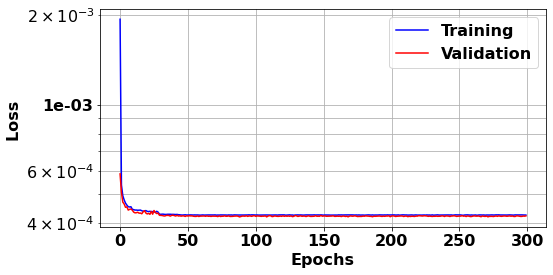

In [19]:
# saving the model 
# old net in './Network/LSTM_Otway.pth'

torch.save(model.state_dict(),f'{net_path}LSTM_SEAM_epc{epoch}{hyperpar}.pth')

loss_arr = np.array(loss_arr)
loss_arr_test = np.array(loss_arr_test) 

np.save(f'./loss_arr/Training_loss_SEAM{hyperpar}',loss_arr)
np.save(f'./loss_arr/Testing_loss_SEAM{hyperpar}',loss_arr_test)
# np.save('./loss_arr/Training_R2_Otway',np.array(R2_train))
# np.save('./loss_arr/Testing_R2_Otway',np.array(R2_test))

plot_history(loss_arr,loss_arr_test,'Fig/loss_SEAM{hyperpar}')


# plot_r2(R2_train,R2_test,'Fig/R2_Otway')


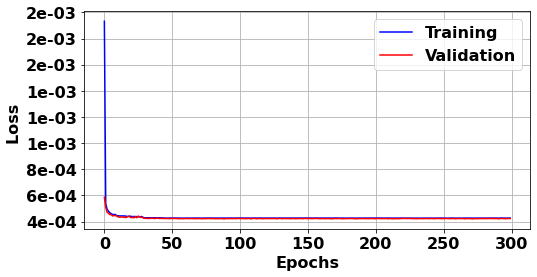

In [20]:
def plot_history(trainingloss,testingloss,netname):

    Epc = np.arange(1,trainingloss.shape[0]+1)
    fig, ax = plt.subplots(figsize=(8,4))

    ax.plot(trainingloss,color='b',label='Training')
    ax.plot(testingloss,color='r',label='Validation')

    ax.grid(which='both')
    ax.set_xlabel('Epochs', fontsize=16, fontweight='bold')
    ax.set_ylabel('Loss ',fontsize=16, fontweight='bold')

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0e'))

    ax.tick_params(axis='both',which='minor',labelsize=16)
    plt.xticks(fontsize=16,fontweight='semibold')
    plt.yticks(fontsize=16,fontweight='semibold')
    ax.legend(prop={'size': 16, 'weight':'bold'})

    name=netname+'.png'
    fig.savefig(name, bbox_inches='tight')

    
plot_history(loss_arr,loss_arr_test,'Fig/loss_SEAM{hyperpar}')
